# Descriptive Statistics and Interval Estimation

In [1]:
# To manipulate arrays
import numpy as np

# To manipulate datasets
import pandas as pd

# To plot
import seaborn as sns
import matplotlib.pyplot as plt

# To integrate a function
from scipy import integrate

# Gamma function
from scipy.special import gamma

# To calculate statistics
from scipy.stats import norm, t, chi2
from scipy.stats import hmean, trim_mean, iqr, median_abs_deviation, skew, kurtosis
from scipy.stats.mstats import gmean, winsorize
from statsmodels.distributions import ECDF

In [2]:
# Significance level
ALPHA = 0.05

---

In [3]:
class Statistics():

    ######################################
    ## Function to initialize the class ##
    ######################################

    def __init__(self, data):
        self.data = data    # Assign the data to the attribute data
        self.n = len(data)  # Assign the number of observations to the attribute n

    ###############
    ## Quantiles ##
    ###############

    def CalculateQuantiles(self, prob):
        if type(prob) is list:
            self.quantiles = pd.DataFrame({'Value': np.quantile(self.data, prob)}, ['Q{}'.format(p) for p in prob])
        else:
            self.quantiles = pd.DataFrame({'Value': np.quantile(self.data, prob)}, ['Q{}'.format(prob)])

    ###############
    ## Quartiles ##
    ###############

    def CalculateQuartiles(self):
        self.quartiles = pd.DataFrame({'Value': np.quantile(self.data, [0.25,0.5,0.75])},['Q1', 'Q2', 'Q3'])

    ######################
    ## Central Tendency ##
    ######################

    def CalculateCentralTendency(self, trim_param=0.1, winsor_param=[0.1,0.1], weights=None):

        # Winsorized data
        data_winsorized = winsorize(self.data, winsor_param)

        #Mode = mode(data) # To calculate the mode 
        self.mean = self.data.mean()
        self.median = np.median(self.data)
        trimmed_mean = trim_mean(self.data, trim_param)
        interquartile_mean = trim_mean(self.data, 0.25)
        winsorized_mean = data_winsorized.mean()

        if np.all(self.data > 0): # If all observations are greater than zero, calculate geometric and harmonic mean
            geometric_mean = gmean(self.data)
            harmonic_mean = hmean(self.data)
        else:
            geometric_mean = np.nan
            harmonic_mean = np.nan

        if weights is None: # If weights are given for the observations, calculate the weighted mean
            weighted_mean = np.nan
        else:
            weighted_mean = np.average(self.data, weights=weights)

        # Write the statistics in a list
        central_tendency = [self.mean, self.median, geometric_mean, harmonic_mean, weighted_mean, trimmed_mean, interquartile_mean, winsorized_mean]

        # Return the statistics as a table
        labels = ['Mean', 'Median', 'GeometricMean', 'HarmonicMean', 'WeightedMean', 'TrimmedMean', 'InterquartileMean', 'WinsorizedMean']
        self.central_tendency = pd.DataFrame({'Value': central_tendency,'Robust': [1, 0, 0, 0, 0, 1, 1, 1]}, labels)

    ################
    ## Dispersion ##
    ################

    # Auxiliary functions to correct for the bias
    def c4(self, n):
        return np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)

    def d2(self, n):
        f = lambda x, n: 1 - (1 - norm.cdf(x))**n - (norm.cdf(x))**n
        return round(integrate.quad(f, -np.inf, np.inf, args=(n,))[0], 3)
    
    def CalculateDispersion(self):

        # Original estimators
        self.S0 = np.std(self.data)             # By default the standard deviation is calculated with zero degrees of freedom
        self.S1 = np.std(self.data, ddof=1)     # Standard deviation with one degree of freedom
        R = self.data.max() - self.data.min()
        IQR = iqr(self.data)                
        MAD = median_abs_deviation(self.data)   
        AAD = abs(self.data - self.data.mean()).mean()

        # Bias correction
        S0_bias_correct = self.S0 * np.sqrt(self.n/(self.n-1)) / self.c4(self.n)
        S1_bias_corrected = self.S1 / self.c4(self.n)
        R_bias_corrected = R / self.d2(self.n)
        IQR_bias_corrected = IQR / (2 * norm.ppf(0.75))
        MAD_bias_corrected = MAD / norm.ppf(0.75)
        AAD_bias_corrected = AAD * np.sqrt(np.pi/2)

        # Write the statistics in a list
        sigma_biased = [self.S0, self.S1, R, IQR, MAD, AAD]
        sigma_unbiased = [S0_bias_correct, S1_bias_corrected, R_bias_corrected, IQR_bias_corrected, MAD_bias_corrected, AAD_bias_corrected]

        # Return the statistics as a table
        labels = ['Deviation, ddof=0', 'Deviation, ddof=1', 'Range', 'IQR', 'MAD', 'AAD']
        self.dispersion = pd.DataFrame({'Value':sigma_biased, 'Value_bias_corrected':sigma_unbiased, 'Robust':[0,0,0,1,1,1]}, labels)

    ##########
    ## Skew ##
    ##########

    def CalculateSkewness(self):
        SkewCentralMoments = skew(self.data)
        SkewKStatistics = skew(self.data, bias=False)

        self.skew = pd.DataFrame({'Value':[SkewCentralMoments, SkewKStatistics]}, ['SkewCentralMoments', 'SkewKStatistics'])
    
    ##############
    ## Kurtosis ##
    ##############

    def CalculateKurtosis(self):
        KurtosisCentralMoments = kurtosis(self.data, fisher=False)
        KurtosisKStatistics = kurtosis(self.data, fisher=False, bias=False)

        self.kurtosis = pd.DataFrame(
            {'Value':[KurtosisCentralMoments, KurtosisKStatistics], 'ExcessKurtosis':[KurtosisCentralMoments-3, KurtosisKStatistics-3]},
            ['KurtosisCentralMoments', 'KurtosisKStatistics']
        )

    def CalculateDescriptiveStatistics(self, trim_param=0.1, winsor_param=[0.1,0.1], weights=None):
        self.CalculateQuartiles()
        self.CalculateCentralTendency(trim_param, winsor_param, weights)
        self.CalculateDispersion()
        self.CalculateSkewness()
        self.CalculateKurtosis()

    ###########################
    ## Statistical Inference ##
    ###########################

    ##########################
    ## Confidence Intervals ##
    ##########################

    def CalculateCiMean(self, alpha, hat_mean=None, hat_sigma=None, dist="t"):
        # Calculate confidence interval based on the mean
        if hat_mean is None:
            hat_mean = self.mean
        if hat_sigma is None:
            hat_sigma = self.S1

        scale = hat_sigma / np.sqrt(self.n)
        if dist=="norm":
            self.ci_mean = norm.ppf(alpha/2, hat_mean, scale), norm.ppf(1-alpha/2, hat_mean, scale)
        if dist=="t":
            # Only if we are using standard deviaiton with one degree of freedom without correction
            self.ci_mean = t.ppf(alpha/2, self.n-1, hat_mean, scale), t.ppf(1-alpha/2, self.n-1, hat_mean, scale)
        
    def CalculateCiMedian(self, alpha, hat_median=None, hat_sigma=None):
        # Calculate confidence interval based on the median
        if hat_median is None:
            hat_median = self.median
        if hat_sigma is None:
            hat_sigma = self.S1
        
        scale = hat_sigma * np.sqrt(np.pi/(2*self.n))
        self.ci_median = norm.ppf(alpha/2, hat_median, scale), norm.ppf(1-alpha/2, hat_median, scale)

    def CalculateCiDeviation(self, alpha):
        # Calculate confidence interval for the standard deviation
        num = self.S1 * np.sqrt(self.n-1)
        den_low = np.sqrt(chi2.ppf(1-alpha/2, self.n-1))
        den_upp = np.sqrt(chi2.ppf(alpha/2, self.n-1))

        self.ci_deviation = num/den_low, num/den_upp

    def CalculateConfidenceInterval(self, alpha, hat_mean=None, hat_median=None, hat_sigma=None, dist="t"):
        self.CalculateCiMean(alpha, hat_mean, hat_sigma, dist)
        self.CalculateCiMedian(alpha, hat_median, hat_sigma)
        self.CalculateCiDeviation(alpha)

        # Return the statistics as a table
        labels = ['Mean', 'Median', 'Deviation']
        self.confidence_intervals = pd.DataFrame(
            [self.ci_mean, self.ci_median, self.ci_deviation],
            index=labels, columns=["Lower", "Upper"]
        )

    ##########################
    ## Prediction Intervals ##
    ##########################

    def CalculatePiMean(self, alpha, hat_mean=None, hat_sigma=None, dist="t"):
        # Calculate prediction interval based on the mean
        if hat_mean is None:
            hat_mean = self.mean
        if hat_sigma is None:
            hat_sigma = self.S1
        
        scale = np.sqrt(hat_sigma**2 + hat_sigma**2/self.n)
        if dist == "norm":
            self.pi_mean = norm.ppf(alpha/2, hat_mean, scale), norm.ppf(1-alpha/2, hat_mean, scale)
        if dist == "t":
            # Only if we are using standard deviaiton with one degree of freedom without correction
            self.pi_mean = t.ppf(alpha/2, self.n-1, hat_mean, scale), t.ppf(1-alpha/2, self.n-1, hat_mean, scale)
    
    def CalculatePiMedian(self, alpha, hat_median=None, hat_sigma=None):
        # Calculate prediction interval based on the median
        if hat_median is None:
            hat_median = self.median
        if hat_sigma is None:
            hat_sigma = self.S1

        scale = np.sqrt(hat_sigma**2 + np.pi*hat_sigma**2/(2*self.n))
        self.pi_median = norm.ppf(alpha/2, hat_median, scale), norm.ppf(1-alpha/2, hat_median, scale)

    def CalculatePiIqr(self, alpha):
        # Calculate prediction interval based on the first and third quartile
        q1, q3 = np.quantile(self.data, [0.25, 0.75])
        iqr = q3-q1
        delta = 0.5 * (norm.ppf(1-alpha/2)/norm.ppf(0.75)-1)

        self.pi_iqr = q1 - delta * iqr, q3 + delta * iqr

    def CalculatePredictionInterval(self, alpha, hat_mean=None, hat_median=None, hat_sigma=None, dist="t"):
        self.CalculatePiMean(alpha, hat_mean, hat_sigma, dist)
        self.CalculatePiMedian(alpha, hat_median, hat_sigma)
        self.CalculatePiIqr(alpha)

        # Return the statistics as a table
        labels = ['Mean', 'Median', 'IQR']
        self.prediction_intervals = pd.DataFrame(
            [self.pi_mean, self.pi_median, self.pi_iqr],
            index=labels, columns=["Lower", "Upper"]
        )

    #########################
    ## Relative Likelihood ##
    #########################

    def RelativeLogLikelihood(self, mu, sigma):
        return self.n * (np.log(self.S0 / sigma) + 0.5 * (1 - (np.mean(self.data**2) - 2 * mu * np.mean(self.data) + mu**2) / sigma**2))

    def RelativeLikelihood(self, mu, sigma):
        return np.exp(self.RelativeLogLikelihood(mu, sigma))

    #######################
    ## Graphical Summary ##
    #######################    

    ###################
    ## Hitogram Plot ##
    ###################

    def PlotHistogram(self, kde=True, show_data=False, inference=False, ci="mean", pi="mean", add_normal=True, hat_mu=None, hat_sigma=None):

        _, ax = plt.subplots(1, 1)

        sns.histplot(self.data, stat='density', ax=ax, label="Histogram")
        if kde: # Add a kernel density estimator
            sns.kdeplot(self.data, color='k', linewidth=2, ax=ax, label="KDE")

        if show_data: # Show the observations
            for i in range(len(self.data)):
                plt.axvline(x=self.data[i], ymax=0.05, c='r')
        
        if inference:
            if ci == "mean": # If a confidence interval is given, add it to the plot
                ax.hlines(0.075, self.ci_mean[0], self.ci_mean[1], color='darkorange', label="Confidence interval, mean")
            if ci == "median":
                ax.hlines(0.075, self.ci_median[0], self.ci_median[1], color='darkorange', label="Confidence interval, median")

            if pi == "mean": # If a prediction interval is given, add it to the plot
                ax.hlines(0.05, self.pi_mean[0], self.pi_mean[1], color='red', label="Prediction interval")
            if pi == "median":
                ax.hlines(0.05, self.pi_median[0], self.pi_median[1], color='red', label="Prediction interval")
            if pi == "iqr":
                ax.hlines(0.05, self.pi_iqr[0], self.pi_iqr[1], color='red', label="Prediction interval")

            if add_normal:
                if hat_mu is None:
                    hat_mu = self.mean
                if hat_sigma is None:
                    hat_sigma = self.S1
                    
                y_vect = np.linspace(hat_mu - 3*hat_sigma, hat_mu + 3*hat_sigma, 100)
                ax.plot(y_vect, norm.pdf(y_vect, hat_mu, hat_sigma), color="k", ls="--",  label="Prediction distribution")

        ax.spines[['right', 'top']].set_visible(False) # Do not plot the right and top margins
        plt.legend()
        
    ###############
    ## ECDF plot ##
    ###############

    def PlotEcdf(self, show_data=False):

        ecdf = ECDF(self.data)

        _, ax = plt.subplots(1, 1)

        # In the second subfigure we show the ECDF
        ax.spines[['right', 'top']].set_visible(False) # Do not plot the right and top margins

        # Plot the ECDF
        ax.scatter(ecdf.x, ecdf.y, color='rebeccapurple')        
        ax.step(ecdf.x, ecdf.y, where='post', color='rebeccapurple')

        # Add title and labels to the plot
        ax.set_title("Empirical Cumulative Distribution Function", fontsize=12)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$F_n(x)$')

        # Modify the limits of the vertical and horizontal axes
        ax.set_ylim(0, 1.05)
        ax.set_xlim(self.data.min()-0.05, self.data.max()+0.05)

        if show_data:
            for d in self.data:
                ax.axvline(x=d, ymax=0.05, c='r')                # Plot the observations as a rugplot

    def PlotConfidenceRegions(self, probs=[0.1, 0.5, 0.75, 0.89, 0.95], eps=[0.1, 0.1]):
        probs = probs[::-1] # We need to write the probabilities in a dicreasing order
        
        levels = np.exp(-0.5 * chi2.ppf(probs, 2))

        mu_vect = np.linspace(self.ci_mean[0] - eps[0], self.ci_mean[1] + eps[0], 100)
        sigma_vect = np.linspace(self.ci_deviation[0] - eps[1], self.ci_deviation[1] + eps[1], 100)

        mu_grid, sigma_grid = np.meshgrid(mu_vect, sigma_vect)

        _, ax = plt.subplots(1, 1)

        cnt = ax.contour(mu_grid, sigma_grid, self.RelativeLikelihood(mu_grid, sigma_grid), levels)
        ax.scatter(x=self.mean, y=self.S0, color='k')

        ax.plot(
            [self.ci_mean[0], self.ci_mean[0], self.ci_mean[1], self.ci_mean[1], self.ci_mean[0]],
            [self.ci_deviation[0], self.ci_deviation[1], self.ci_deviation[1], self.ci_deviation[0], self.ci_deviation[0]],
            color='r', ls='--')

        ax.set_title(r"Confidence regions for $\mu$ and $\sigma$")
        ax.set_xlabel(r"$\mu$")
        ax.set_ylabel(r"$\sigma$")

        _, labels = cnt.legend_elements()
        ax.legend(_, probs, loc="upper right", frameon=False)

        ax.spines[['right', 'top']].set_visible(False)

    ##########
    ## Main ##
    ##########
    
    def main(self, alpha, eps=[0.1, 0.1]):
        self.CalculateDescriptiveStatistics(trim_param=0.1, winsor_param=[0.1,0.1], weights=None)
        self.CalculateConfidenceInterval(alpha, hat_mean=None, hat_median=None, hat_sigma=None, dist="t")
        self.CalculatePredictionInterval(alpha, hat_mean=None, hat_median=None, hat_sigma=None, dist="t")
        self.PlotEcdf()
        self.PlotHistogram(kde=False, inference=True)
        self.PlotConfidenceRegions(eps=eps)

---

In [4]:
#DataSet = pd.read_csv("WHR_2023_processed.csv")
#Dat = DataSet["Life Ladder"]

In [5]:
Dat = np.array([1.8, 1.4, 1.2, 1.0, 0.8, 0.1, 4.6, 2.4, 1.3, 1.3])
Weights = norm.pdf(Dat, Dat.mean(), Dat.std()) # Weights for the weighted mean

#Dat = norm.rvs(loc=1, scale=2, size=50)
#Dat = np.concatenate([Dat, norm.rvs(loc=15, scale=2, size=3)])

---

Descriptive Statistics

In [6]:
StatisticsDat = Statistics(Dat)

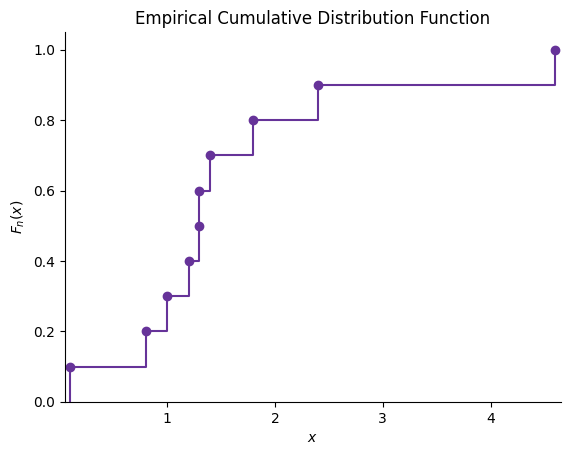

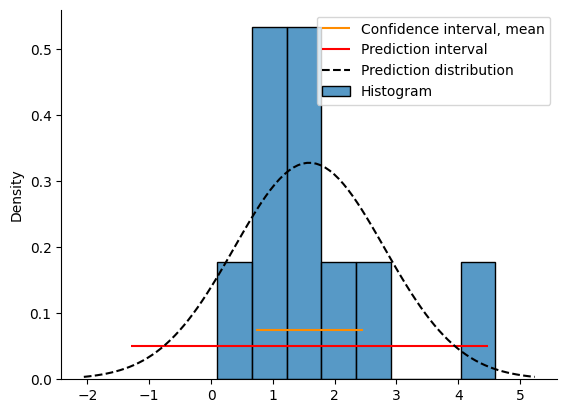

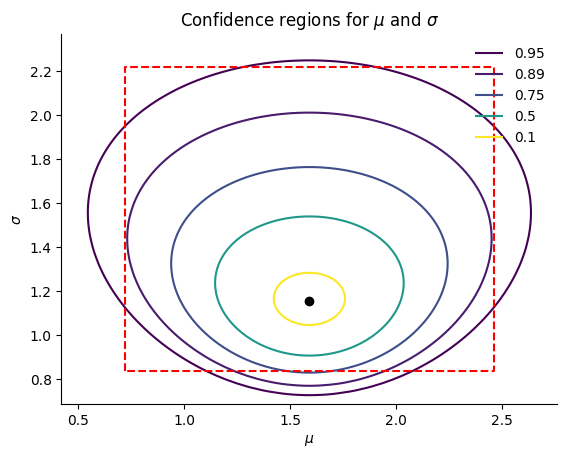

In [7]:
StatisticsDat.main(alpha=ALPHA, eps=[0.3, 0.15])

In [8]:
StatisticsDat.quartiles.round(2)

,Value
Q1,1.05
Q2,1.30
Q3,1.70


In [9]:
StatisticsDat.central_tendency.round(2)

,Value,Robust
Mean,1.59,1
Median,1.30,0
GeometricMean,1.16,0
HarmonicMean,0.61,0
WeightedMean,NaN,0
TrimmedMean,1.40,1
InterquartileMean,1.33,1
WinsorizedMean,1.44,1


In [10]:
StatisticsDat.dispersion.round(2)

,Value,Value_bias_corrected,Robust
"Deviation, ddof=0",1.15,1.25,0
"Deviation, ddof=1",1.22,1.25,0
Range,4.50,1.46,0
IQR,0.65,0.48,1
MAD,0.40,0.59,1
AAD,0.81,1.01,1


In [11]:
StatisticsDat.skew.round(2)

,Value
SkewCentralMoments,1.54
SkewKStatistics,1.83


In [12]:
StatisticsDat.kurtosis.round(2)

,Value,ExcessKurtosis
KurtosisCentralMoments,4.97,1.97
KurtosisKStatistics,7.44,4.44


In [13]:
StatisticsDat.CalculateQuantiles(prob=[0.1, 0.9])
StatisticsDat.quantiles.round(2)

,Value
Q0.1,0.73
Q0.9,2.62


---

Statistical Inference

In [14]:
StatisticsDat.confidence_intervals

,Lower,Upper
Mean,0.720090,2.459910
Median,0.355375,2.244625
Deviation,0.836442,2.220033


In [15]:
StatisticsDat.prediction_intervals

,Lower,Upper
Mean,-1.295164,4.475164
Median,-1.263782,3.863782
IQR,0.430600,2.319400
